<a href="https://colab.research.google.com/github/nadavo11/K_means_cluster/blob/master/EM_Clustering_with_3_gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# GMM Algorithm 
### Dealing With False K Parameter assignment


In this paper, we will deliberatly provide our EM Clustering implementation with a false K value, inconsistant with how our data is formed.
think of it like looking ata dataset and thinking that it can be devided $k$ normaly distributed sub groups when in fact our dataset follows $k' \neq k$ bell curves (normaly distributed sub groups)


in this example, as in previous ones, we will generate our data according to mixed gaussian distribution consisting of two gaussians:
$µ_1 = \begin{bmatrix}
-1 \\
-1 
\end{bmatrix}$
$µ_2 = \begin{bmatrix}
1 \\
1 
\end{bmatrix}$

$\Sigma_1 = \begin{bmatrix}
0.8 & 0 \\
0 & 0.8
\end{bmatrix}$

$\Sigma_2 = \begin{bmatrix}
0.75 & -0.2 \\
-0.2 & 0.6
\end{bmatrix}$

we are given the probability for the first label:

$P_Z(1) = 0.7$

so, K shuld equal 2, but we will set it to 3, to see the effect.

Let us define the datapiont generator:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 10000
k=2
d=2
# first Gussian
mean_1 = [-1, -1]
cov_1 = [[0.75, -0.2], [-0.2, 0.6]]

# second Gussian
mean_2 = [1, 1]
cov_2 = [[0.8, 0], [0, 0.8]]


def generate_normal_datapoint(guaussian_dist):
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov,  check_valid='warn', tol=1e-8)
    dp = [dp[0],dp[1]]
    return dp



## generating a dataset a dataset

In [ ]:
colors = []
data = []
for i in range(N):
    z = np.random.binomial(1, 0.7)
    d = {1: (mean_1, cov_1), 2: (mean_2, cov_2)}
    data.append(generate_normal_datapoint(d[z+1]))
    colors.append(np.random.uniform(0,1)/4+3*z/4)
    

now, lets plot the data (revealing the source of each data point) 

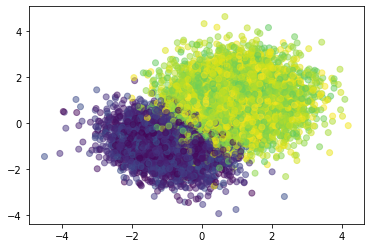

In [ ]:
data = np.array(data)

#colors = np.random.rand(N)
plt.scatter(data[:,0], data[:, 1], c=colors, alpha=0.5)
plt.show()

## using the EM algorithm to cluster the data.

---



pseudo code: The EM algorithm goes as follows

here is EM algorithm in pseudo code

1.until convergence, repeat:
    
   -E-step:
   1. For each data point $x_i$:

        1. Compute the probability that $x_i$ belongs to each of the clusters, $p_{i,j}$

        2. Use these probabilities to compute the expected value of the cluster assignment, $w(i,j) = \frac{P(x_i \in Z_j)*\phi_j}{ \sum_{j = 0}^{k} P(x_i \in Z_j) \cdot \phi_j}$

   -M-step:
   1. For each cluster $j$:

        1. compute the new mean, $\mu_j$

        2. compute the new variance, $\sigma^2_j$

        4. compute the new prior, $ \phi_j$
        
        
this is what the implementation looks like:

In [ ]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as P


def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0
    
    for i in range(n):
        norm_i = 0
        for j in range(k):
            w[j, i] = P(mu[j], sigma[j]).pdf(data[i]) * phi[j]
            norm_i += w[j, i]
        w[:, i] /= norm_i
        
        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w)
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j])
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def EM(data, initial_model):
    # 1. Initialize model parameters
    phi = initial_model[0]
    mu = initial_model[1]
    sigma = initial_model[2]

    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]
    while not converged and i<150:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        phi, mu, sigma = M_step(data, w, phi, mu, sigma)
        
        # Plot:
        if i%20 == 0 or i < 5:
            plt.scatter(data[:,0], data[:, 1], c='red', alpha=0.1)
            for t in range(k):
                draw_contour(phi[t],mu[t],k*sigma[t])
            plt.title("iteration #" + str(i))
            plt.show()
            print("φ: ",phi,"\n\nμ: ", mu,"\n\nσ2: ", sigma,"\n\nlog likelyhood: ", lol)
        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < 0.0001)
    # 5. return model
    return phi, mu, sigma,  iteration_log_likelihood

def draw_contour(phi,mu,sigma):
    N    = 200
    X    = np.linspace(-4, 4, N)
    Y    = np.linspace(-4, 4, N)
    X, Y = np.meshgrid(X, Y)
    pos  = np.dstack((X, Y))
    rv   = P(mu, sigma*phi)
    Z    = rv.pdf(pos)
    plt.contour(X, Y, Z)


### Initial Model:

first, we will need an initial model to start with. EM algorithm demands initial value  $\theta_0$ ie. initial values 
for:  $\mu_j , \sigma^2_j , \phi_j$

one idea would be to use K-means algorithm to initialize the means of the model. we will experiment with tat later, but first we will try initiating with an arbitrary choise, as such:

In [ ]:
def initial_model(k,d):
    """

    :param k: # of Gaussians in model
    :param d: # of dimentions of datapoints
    :return: an arbitrary initial condition  model for EM. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """
    phi = np.random.rand(k)
    phi /= sum(phi)

    mu = np.array([np.random.multivariate_normal([0]*d, np.eye(d,d)) for i in range(k)])
    
    sigmas = np.zeros((k,d,d))
    for i in range(k):
        sigma = np.random.rand(d, d)
        sigma = np.dot(sigma, sigma.T)
        sigmas[i] = sigma
    
    print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigma)
    return phi, mu, sigmas

### convergence conditon:

we will also like to decide when to stop the algorithm. for one thing, we will limit the maximal # of iterations to a fixed number. for another, the algorithm increases the log likelihood, i.e., $ log P(x^n |/theta^t$
so we will calculate the log likelihood at each step, as follows:

Log Likelihood:

$ log P(x^n |\theta ^t )= log(\sum_j P(x^n , z^n ;\theta ^t))$


$= log( \prod_i\sum_j  N(x_i, \mu_j , \sigma^2_j ; \theta ^t)* \phi_j)$


$= \sum_i log( \sum_j  w(j,i))$

$= $
and compare to previous value, to check for convergence.

## False K Clustering:

let us check how te algorithm behaves when provided with a false K value, 3 when in fact the data fits a 2 gaussians model: 

phi:  [0.34508664 0.38114218 0.27377118] 

mu:  [[ 1.62358745 -0.08628487]
 [ 1.09209683  0.2185958 ]
 [-0.10086295 -1.60990485]] 

sigma:  [[0.28647697 0.57591809]
 [0.57591809 1.25363124]]


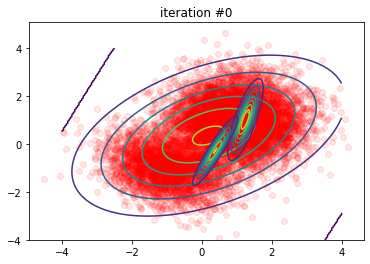

φ:  [0.7121785  0.17973346 0.10808804] 

μ:  [[ 0.19594884  0.34502298]
 [ 1.24593773  1.01643471]
 [ 0.38465964 -0.28286452]] 

σ2:  [[[1.97516835 0.75811708]
  [0.75811708 1.45050271]]

 [[0.1147858  0.29883854]
  [0.29883854 1.31861084]]

 [[0.32908056 0.68784519]
  [0.68784519 1.66914516]]] 

log likelyhood:  76317.3560946534


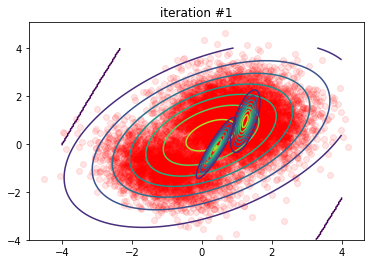

φ:  [0.78898956 0.13337886 0.07763158] 

μ:  [[ 0.26428136  0.36106993]
 [ 1.24116731  0.94550475]
 [ 0.39936889 -0.16951545]] 

σ2:  [[[1.86477131 0.78770991]
  [0.78770991 1.55615229]]

 [[0.10969241 0.21682202]
  [0.21682202 1.04634982]]

 [[0.33939755 0.70856349]
  [0.70856349 1.7759151 ]]] 

log likelyhood:  32259.31809885587


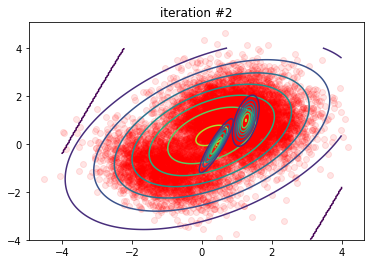

φ:  [0.82148852 0.11624424 0.06226723] 

μ:  [[ 0.28382421  0.35299419]
 [ 1.25771642  0.96753722]
 [ 0.41279703 -0.07420122]] 

σ2:  [[[1.81402034 0.78738731]
  [0.78738731 1.58634976]]

 [[0.10746421 0.15031439]
  [0.15031439 0.83373341]]

 [[0.35115624 0.73590916]
  [0.73590916 1.89405778]]] 

log likelyhood:  31851.428808946497


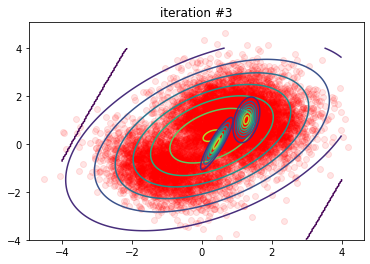

φ:  [0.83708013 0.11009436 0.05282552] 

μ:  [[0.28929353 0.34254869]
 [1.27523484 1.00210549]
 [0.42605036 0.01446529]] 

σ2:  [[[1.78659434 0.78521235]
  [0.78521235 1.60152647]]

 [[0.10988151 0.098624  ]
  [0.098624   0.68006541]]

 [[0.35814546 0.754657  ]
  [0.754657   1.99291788]]] 

log likelyhood:  31709.50282393065


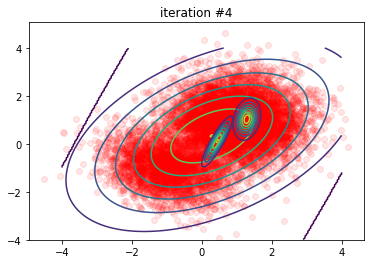

φ:  [0.84383152 0.10978734 0.04638114] 

μ:  [[0.28823469 0.33208826]
 [1.28888031 1.02956698]
 [0.43854225 0.09855385]] 

σ2:  [[[1.77076376 0.78397252]
  [0.78397252 1.61167141]]

 [[0.11733926 0.05980413]
  [0.05980413 0.58034134]]

 [[0.36023964 0.76345   ]
  [0.76345    2.06910034]]] 

log likelyhood:  31630.304762447366


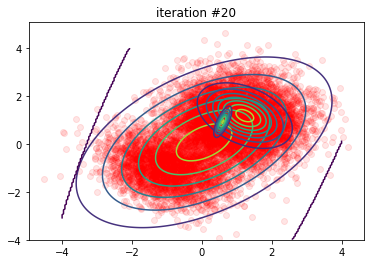

φ:  [0.69748325 0.28309393 0.01942282] 

μ:  [[0.06504361 0.0660085 ]
 [1.2294713  1.17943104]
 [0.59938074 0.92166892]] 

σ2:  [[[ 1.70393422  0.79881823]
  [ 0.79881823  1.60906167]]

 [[ 0.5397941  -0.2139819 ]
  [-0.2139819   0.54563383]]

 [[ 0.31358036  0.57461774]
  [ 0.57461774  2.03106861]]] 

log likelyhood:  31163.636539077557


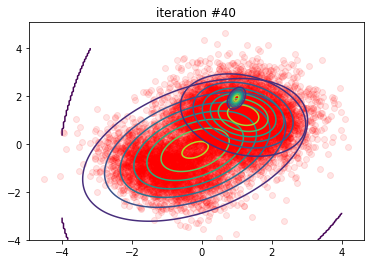

φ:  [0.56311284 0.41843494 0.01845222] 

μ:  [[-0.19189651 -0.24890733]
 [ 1.18262025  1.20175512]
 [ 0.99034756  1.90424663]] 

σ2:  [[[ 1.55429618  0.59056998]
  [ 0.59056998  1.32828502]]

 [[ 0.66947977 -0.14520653]
  [-0.14520653  0.61517847]]

 [[ 0.31383384  0.2057734 ]
  [ 0.2057734   0.97828523]]] 

log likelyhood:  31056.09205191344


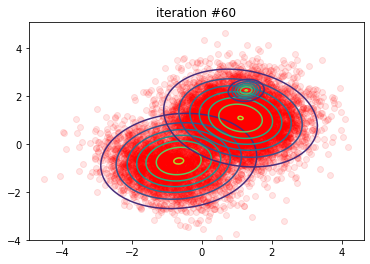

φ:  [0.39996482 0.56936205 0.03067313] 

μ:  [[-0.66119031 -0.71234258]
 [ 1.10755734  1.07888211]
 [ 1.26873565  2.23219588]] 

σ2:  [[[ 1.06154457  0.09281996]
  [ 0.09281996  0.84018669]]

 [[ 0.72628069 -0.11083213]
  [-0.11083213  0.62386689]]

 [[ 0.79776617  0.07705571]
  [ 0.07705571  0.64471669]]] 

log likelyhood:  30856.204707738674


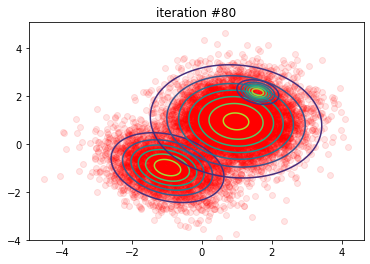

φ:  [0.30468443 0.6577618  0.03755377] 

μ:  [[-0.98201068 -0.98908896]
 [ 0.97921464  0.93954215]
 [ 1.602442    2.16212838]] 

σ2:  [[[ 0.75244461 -0.17886046]
  [-0.17886046  0.61079006]]

 [[ 0.76630522 -0.0568836 ]
  [-0.0568836   0.70923548]]

 [[ 0.82449538 -0.19466162]
  [-0.19466162  0.6039263 ]]] 

log likelyhood:  30679.84248939138


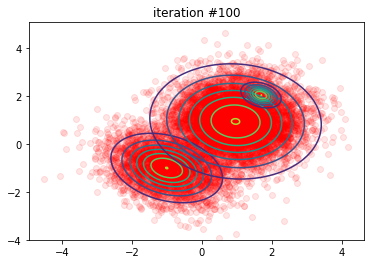

φ:  [0.29744065 0.66727385 0.0352855 ] 

μ:  [[-1.00548246 -1.00545643]
 [ 0.96570219  0.93665325]
 [ 1.69327016  2.0373918 ]] 

σ2:  [[[ 0.7337686  -0.19234154]
  [-0.19234154  0.60211715]]

 [[ 0.77086365 -0.04299302]
  [-0.04299302  0.73917562]]

 [[ 0.80557491 -0.23024808]
  [-0.23024808  0.69839362]]] 

log likelyhood:  30676.85167126845


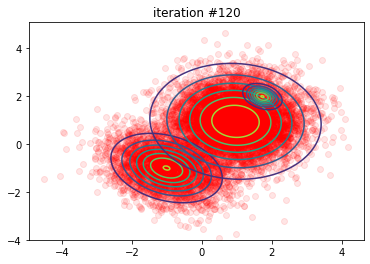

φ:  [0.29648846 0.66976856 0.03374298] 

μ:  [[-1.00879519 -1.00696491]
 [ 0.96397462  0.94026588]
 [ 1.73430421  1.9744535 ]] 

σ2:  [[[ 0.73100712 -0.19371544]
  [-0.19371544  0.60179094]]

 [[ 0.7702454  -0.03931742]
  [-0.03931742  0.74871844]]

 [[ 0.80019294 -0.23863915]
  [-0.23863915  0.75076915]]] 

log likelyhood:  30676.578674507142


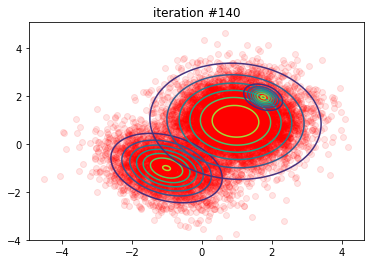

φ:  [0.29611105 0.67118295 0.03270599] 

μ:  [[-1.01009774 -1.00751533]
 [ 0.96361567  0.94243613]
 [ 1.75512325  1.94522033]] 

σ2:  [[[ 0.72993677 -0.19421725]
  [-0.19421725  0.6017172 ]]

 [[ 0.77015193 -0.03745781]
  [-0.03745781  0.75313727]]

 [[ 0.7969664  -0.24196099]
  [-0.24196099  0.77689287]]] 

log likelyhood:  30676.511788466305


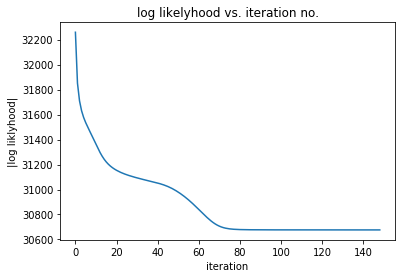

In [ ]:
k=3
d=2

phi, mu, sigma, lol = EM(data,initial_model(k,d))

plt.plot(range(len(lol[2:])),lol[2:])
plt.title("log likelyhood vs. iteration no.")
plt.xlabel("iteration")
plt.ylabel("|log liklyhood|")
plt.show()

surprisingly, the algorithm delt pretty good with the false $K$ assignment, we can see two relatively accurate mean and variance values as well as two gaussians that fit the shape of the original data generating gaussians.
we see a smaller one blending in one of the formers, the amplitude of both summs up to one of the true anplitudes, $\phi_2$ , so the extra cluster "steals" from its host's amplitude, but merely effects it's $\mu$ and $\sigma^2$
computationally, a segnificant cost was added, so mischoosing k wasn't a good idea, yet not such a great desaster.